In [1]:
import cv2 # OpenCV
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import os
from matplotlib import pyplot as plt
# from google.colab.patches import cv2_imshow
# cv2.__version__

In [2]:
imgs_dir = r'../aula02/imagens/originais/'
imgs_transf = r'imagens/transformadas/'

In [3]:
#função de Informação Espacial

def Inf_spatial(img_grayscale):
  sh = cv2.Sobel(img_grayscale, cv2.CV_64F, 1, 0, ksize = 1)
  sv = cv2.Sobel(img_grayscale, cv2.CV_64F, 0, 1, ksize = 1)

  #SIr = np.sqrt (sh **2 + sv **2)
  SIr = np.sqrt(np.square(sh) + np.square(sv))

  SI_mean = np.sum(SIr) / (SIr.shape[0] * SIr.shape[1])
  SI_rms = np.sqrt(np.sum(SIr ** 2) / (SIr.shape[0] * SIr.shape[1]))
  SI_stdev = np.sqrt(np.sum(SIr ** 2 - SI_mean ** 2) / (SIr.shape[0] * SIr.shape[1]))

  return SI_stdev

In [4]:
# Leitura das imagens no diretório e carga em dicionário de imagens

imgs = {}

for file in os.listdir(imgs_dir):

  # Carregar imagem original, entrada para o processamento
  img_original = os.path.join(imgs_dir, file)
  img_gray = cv2.imread(img_original, cv2.IMREAD_GRAYSCALE)

  img_id = file.split('-')[0]

  imgs[img_id] = img_gray

In [5]:
# Confirmação das imagens armazenadas e suas dimensões

for img_id, img in imgs.items():
  print(f'Imagem {img_id}: {img.shape}')

Imagem cairn: (720, 1280)
Imagem runner: (850, 1280)
Imagem shutters: (854, 1280)
Imagem swan: (752, 1280)


In [6]:
# Informação Espacial

for img_id, img in imgs.items():
  img_is = Inf_spatial(img)
  print(f'Imagem {img_id}: {img_is}')



Imagem cairn: 20.565907582572947
Imagem runner: 18.757542176005956
Imagem shutters: 39.39472001525511
Imagem swan: 17.295694652690116


In [7]:
# Cálculo e carga dos histogramas em dicionário

img_hists = {}

for img_id, img in imgs.items():
  img_hist = cv2.calcHist([img],[0],None,[256],[0,256])
  img_hists[img_id] = img_hist


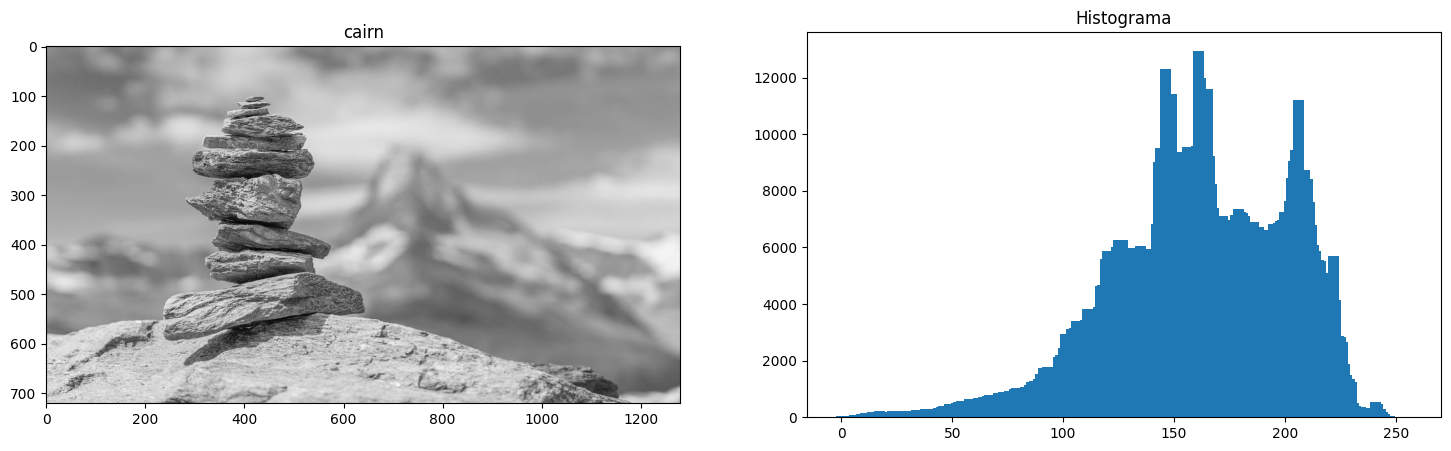

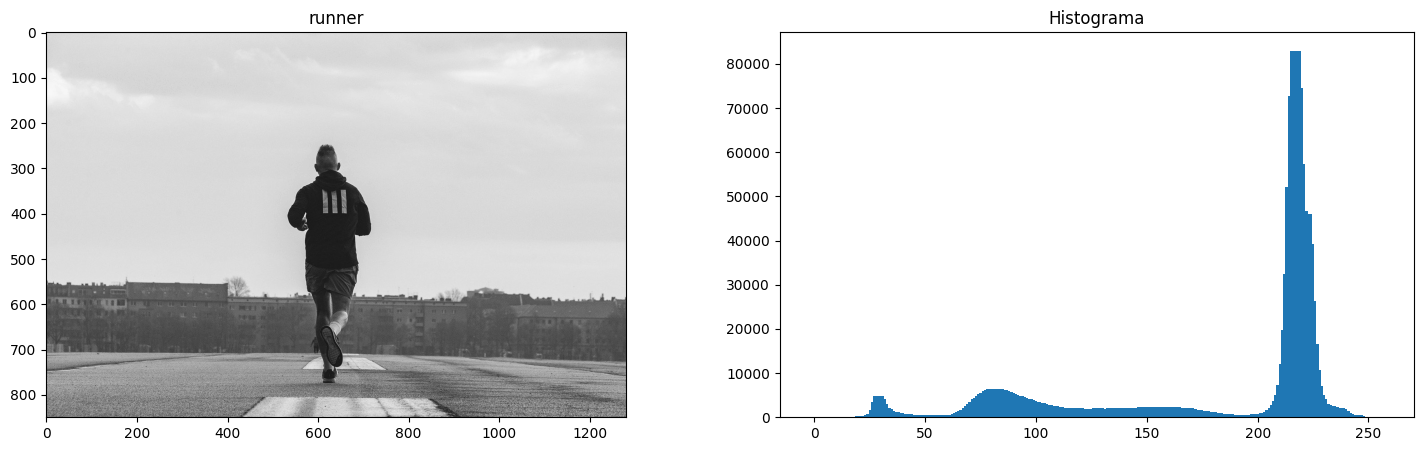

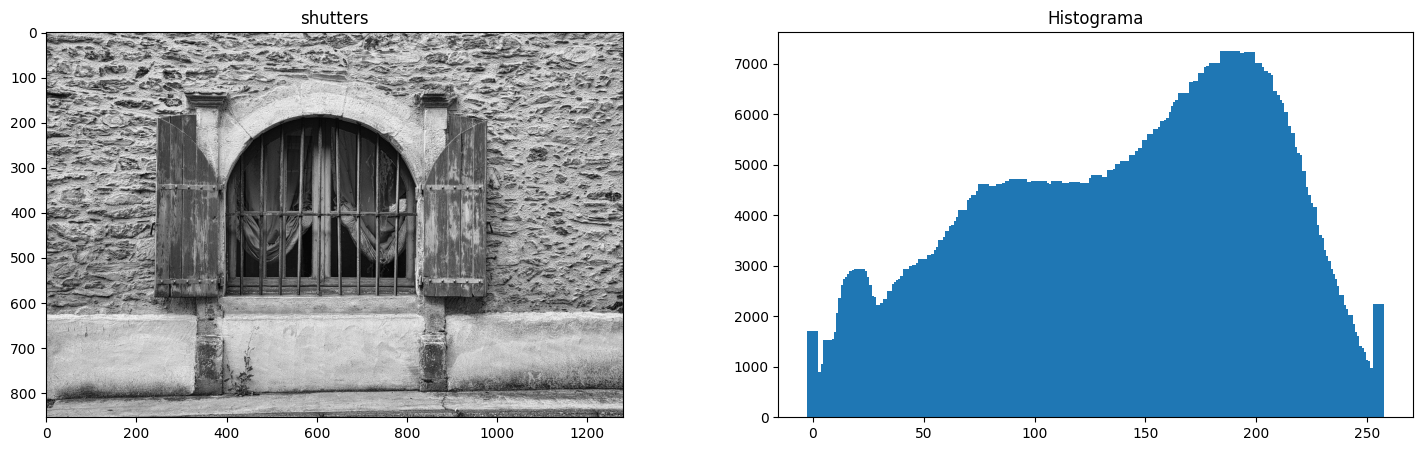

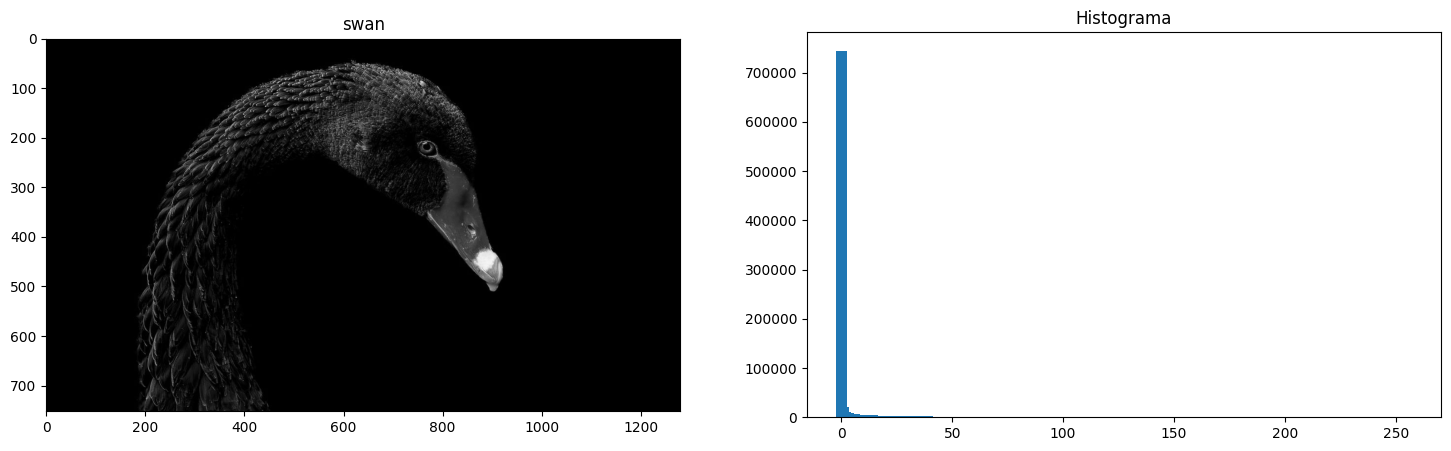

In [8]:
# Plotagem dos histogramas das imagens originais

intensity_values = np.array([x for x in range(256)])


for img_id, img in imgs.items():
    
    fig, axs = plt.subplots(1, 2, figsize=(18, 5))

    axs[0].set_title(f'{img_id}')
    axs[0].imshow(img, cmap='gray')

    axs[1].set_title('Histograma')
    axs[1].bar(intensity_values, img_hists[img_id][:,0],width = 5)

    plt.show()

In [9]:
BIT_8 = 128
BIT_7 = 64
BIT_6 = 32
BIT_5 = 16
BIT_4 = 8
BIT_3 = 4
BIT_2 = 2
BIT_1 = 1

def set_img_bits(img, mask):

  masked_img = np.zeros(img.shape, dtype=np.uint8)

  for line in range(img.shape[0]):
    for col in range(img.shape[1]):

      pixel = img[line, col]
      pixel = pixel & mask

      masked_img[line, col] = pixel

  return masked_img


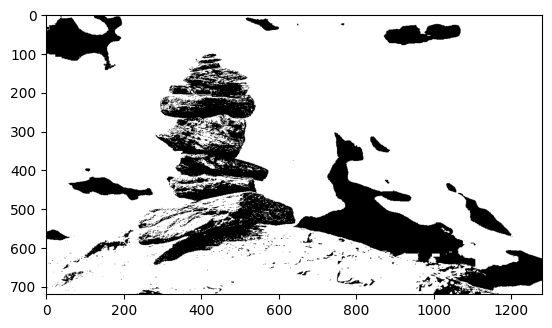

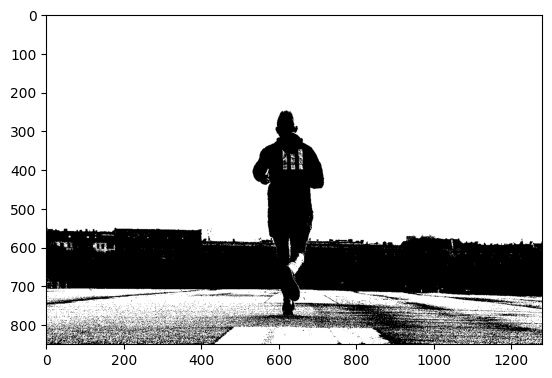

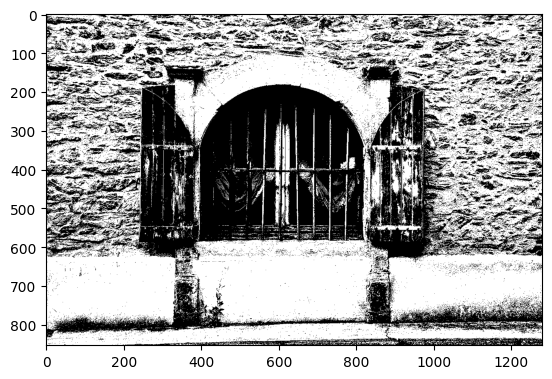

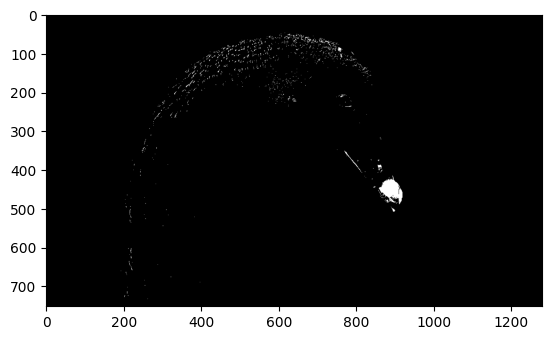

In [10]:
masked_imgs = {}

for img_id, img in imgs.items():
  masked_imgs[img_id] = set_img_bits(img, BIT_8)

for img in masked_imgs.values():
  # cv2_imshow(img)
  plt.imshow(img, cmap='gray')
  plt.show()

In [11]:
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(src, table)

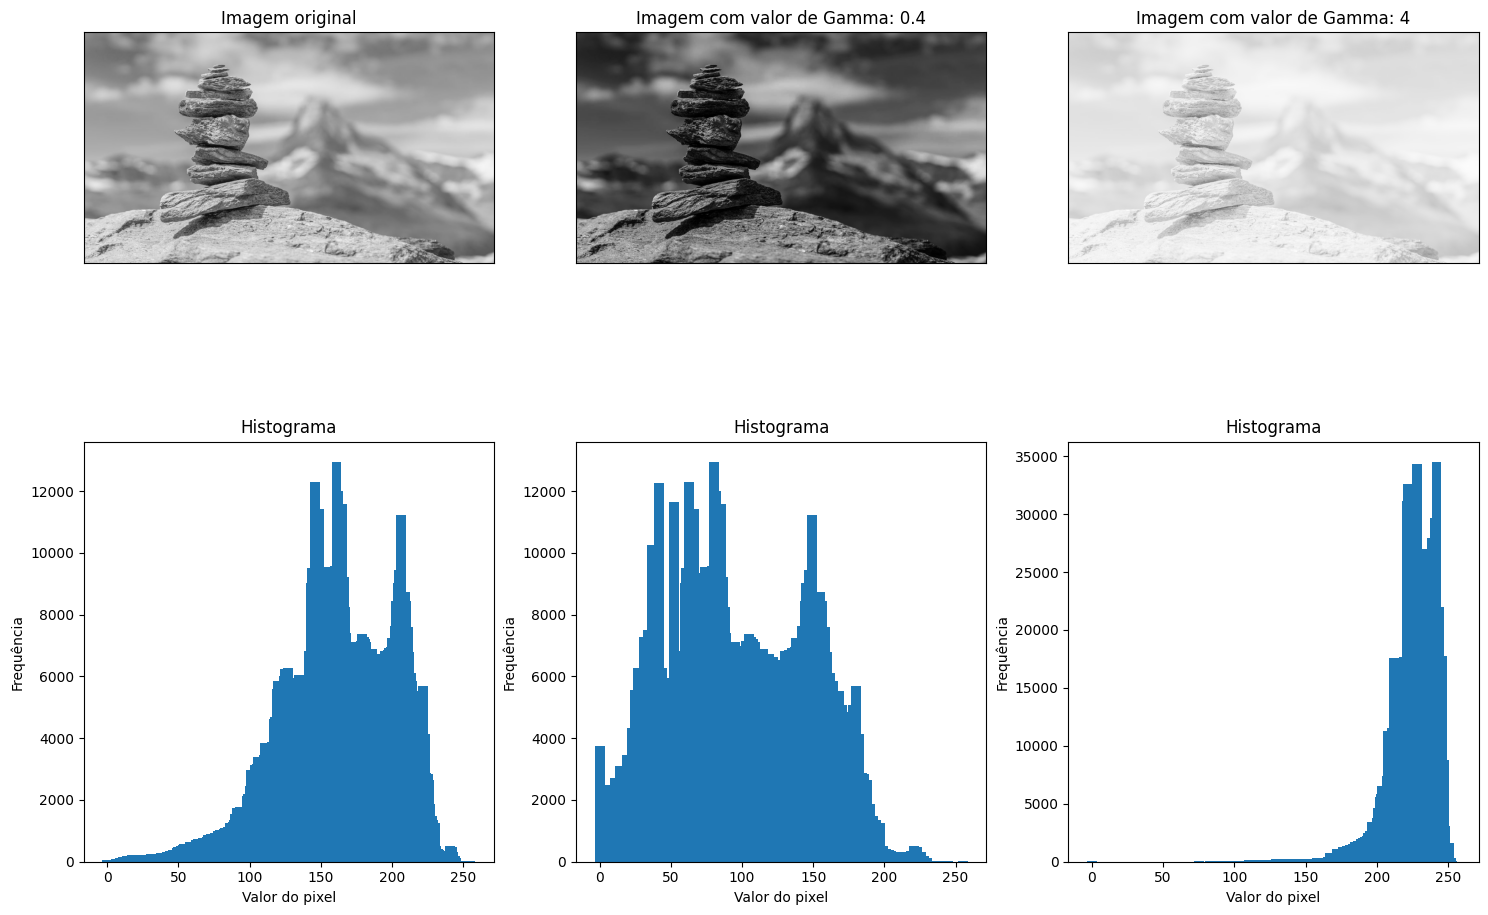

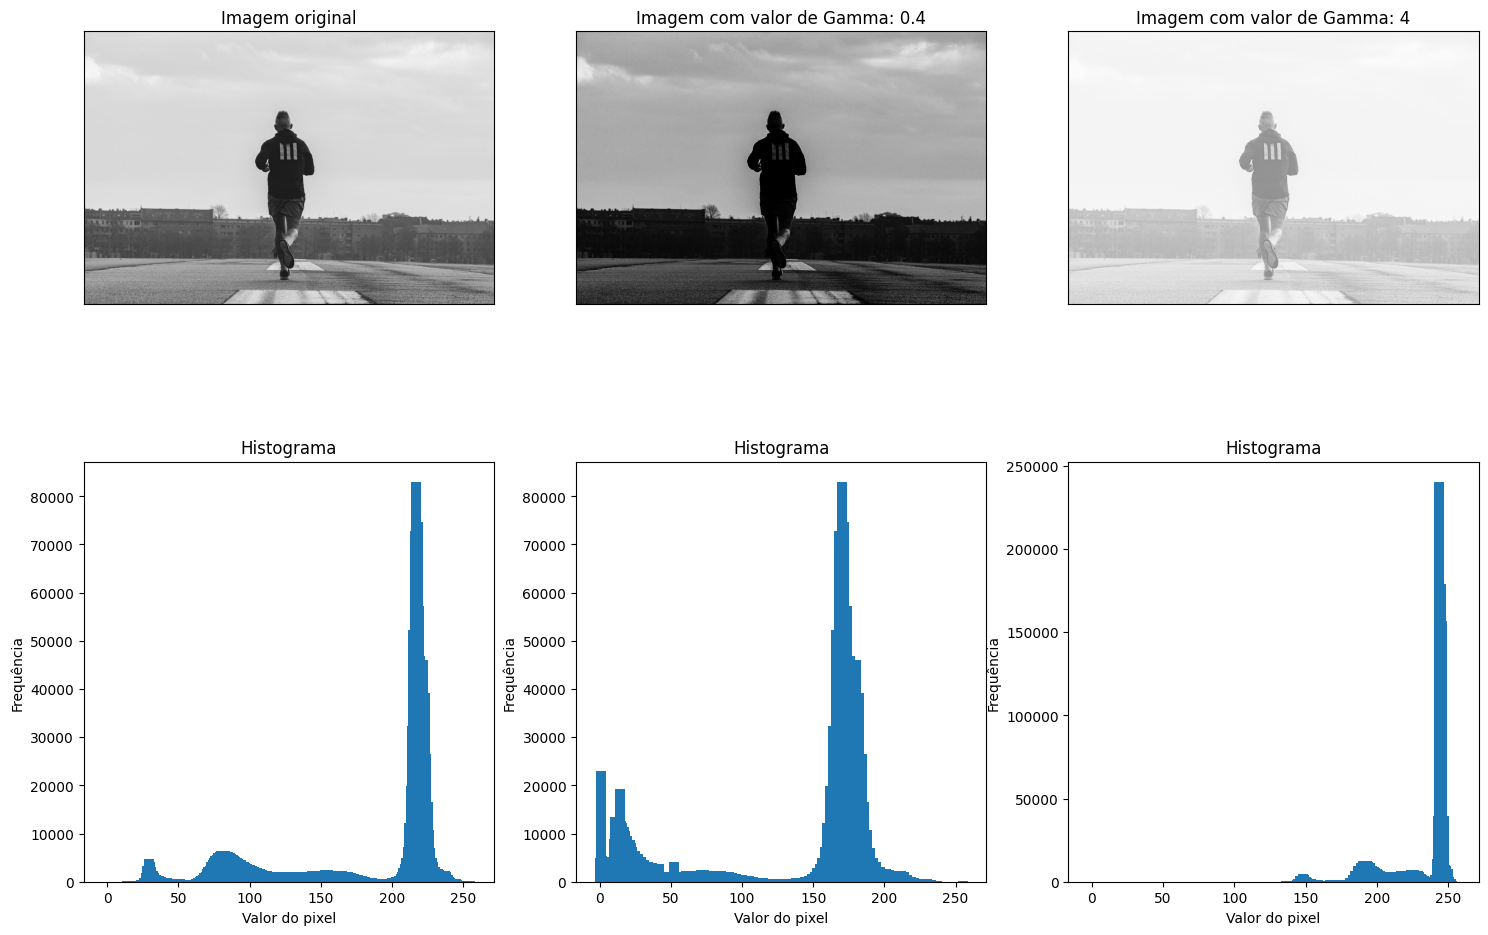

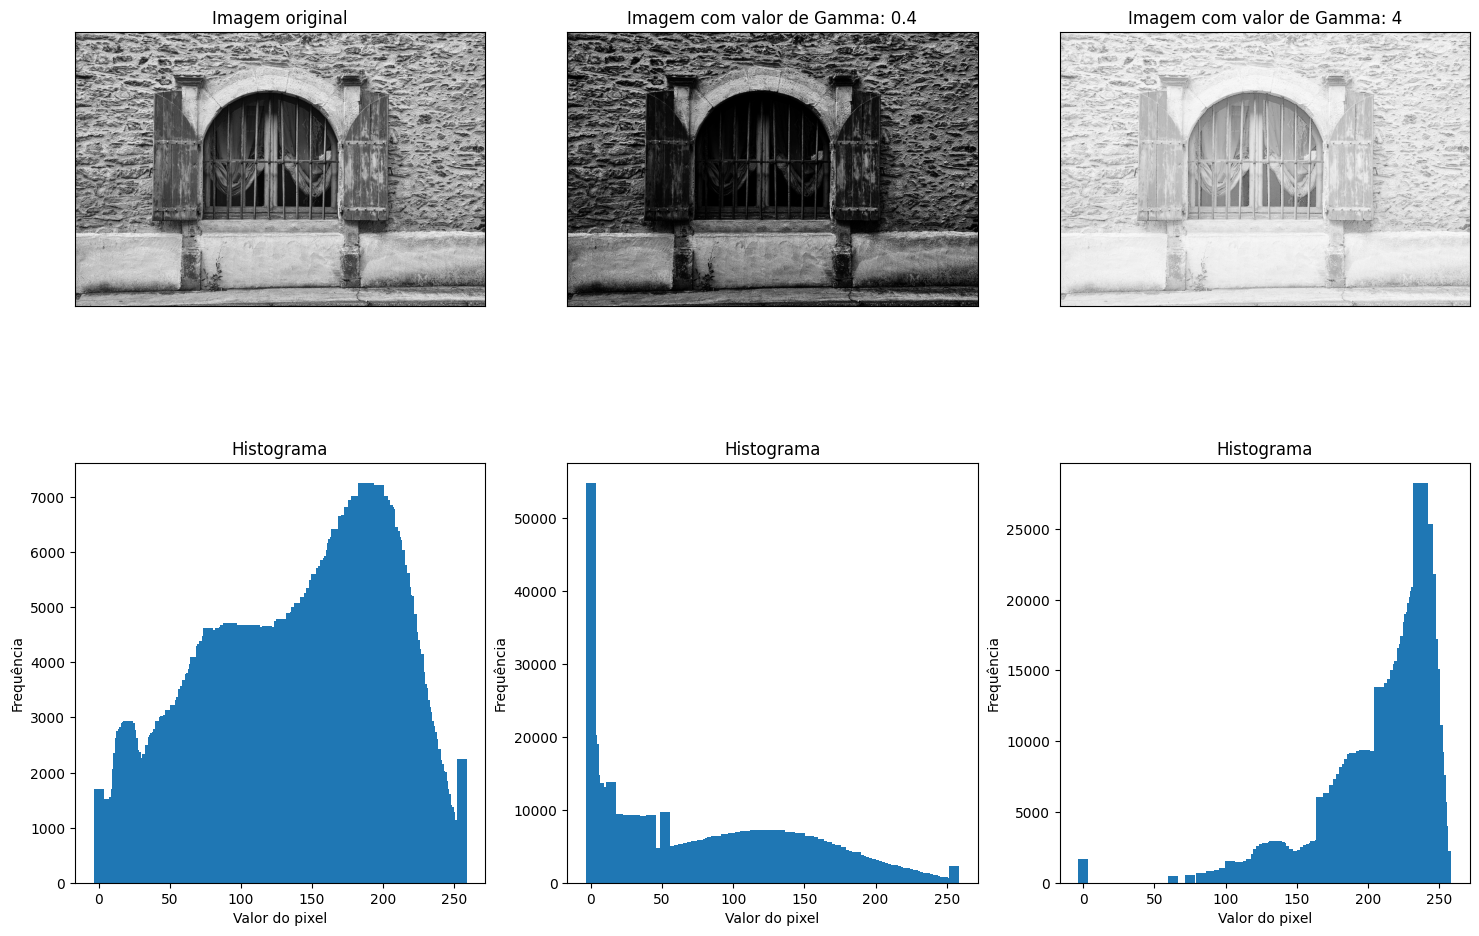

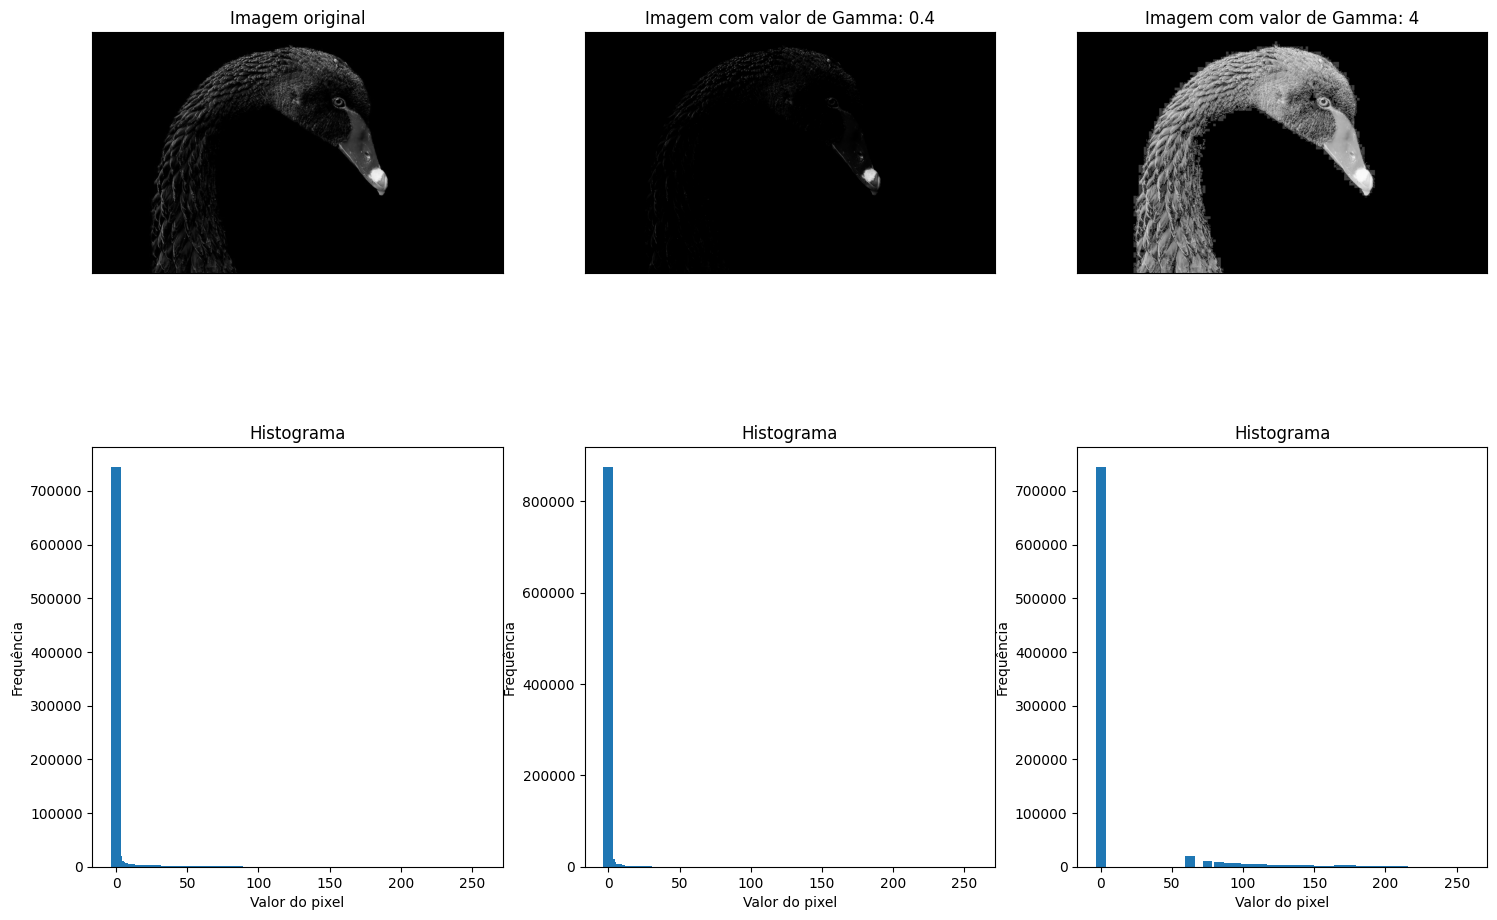

In [12]:
gamma_values = [0.4, 4]
intensity_values = np.array([x for x in range(256)])
imagens_gamma = []

for img_id, img in imgs.items():
    imagens = []
    titulos = []
    imagens.append(img)
    titulos.append('Imagem original')

    for g in gamma_values:
        img_gc = gammaCorrection(img, g)
        imagens.append(img_gc)
        titulos.append(f'Imagem com valor de Gamma: {g}')

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    for i in range(3):
        axes[0, i].imshow(cv2.cvtColor(imagens[i], cv2.COLOR_BGR2RGB), cmap='gray')
        axes[0, i].set_title(titulos[i])
        axes[0, i].set_xticks([]), axes[0, i].set_yticks([])

    for i in range(3):
        hist = cv2.calcHist([imagens[i]], [0], None, [256], [0,256])
        axes[1, i].bar(intensity_values, hist[:,0], width = 7)
        axes[1, i].set_title(f'Histograma')
        axes[1, i].set_xlabel('Valor do pixel')
        axes[1, i].set_ylabel('Frequência')

    # plt.tight_layout()
    plt.show()
    
    imagens_gamma.append(imagens)


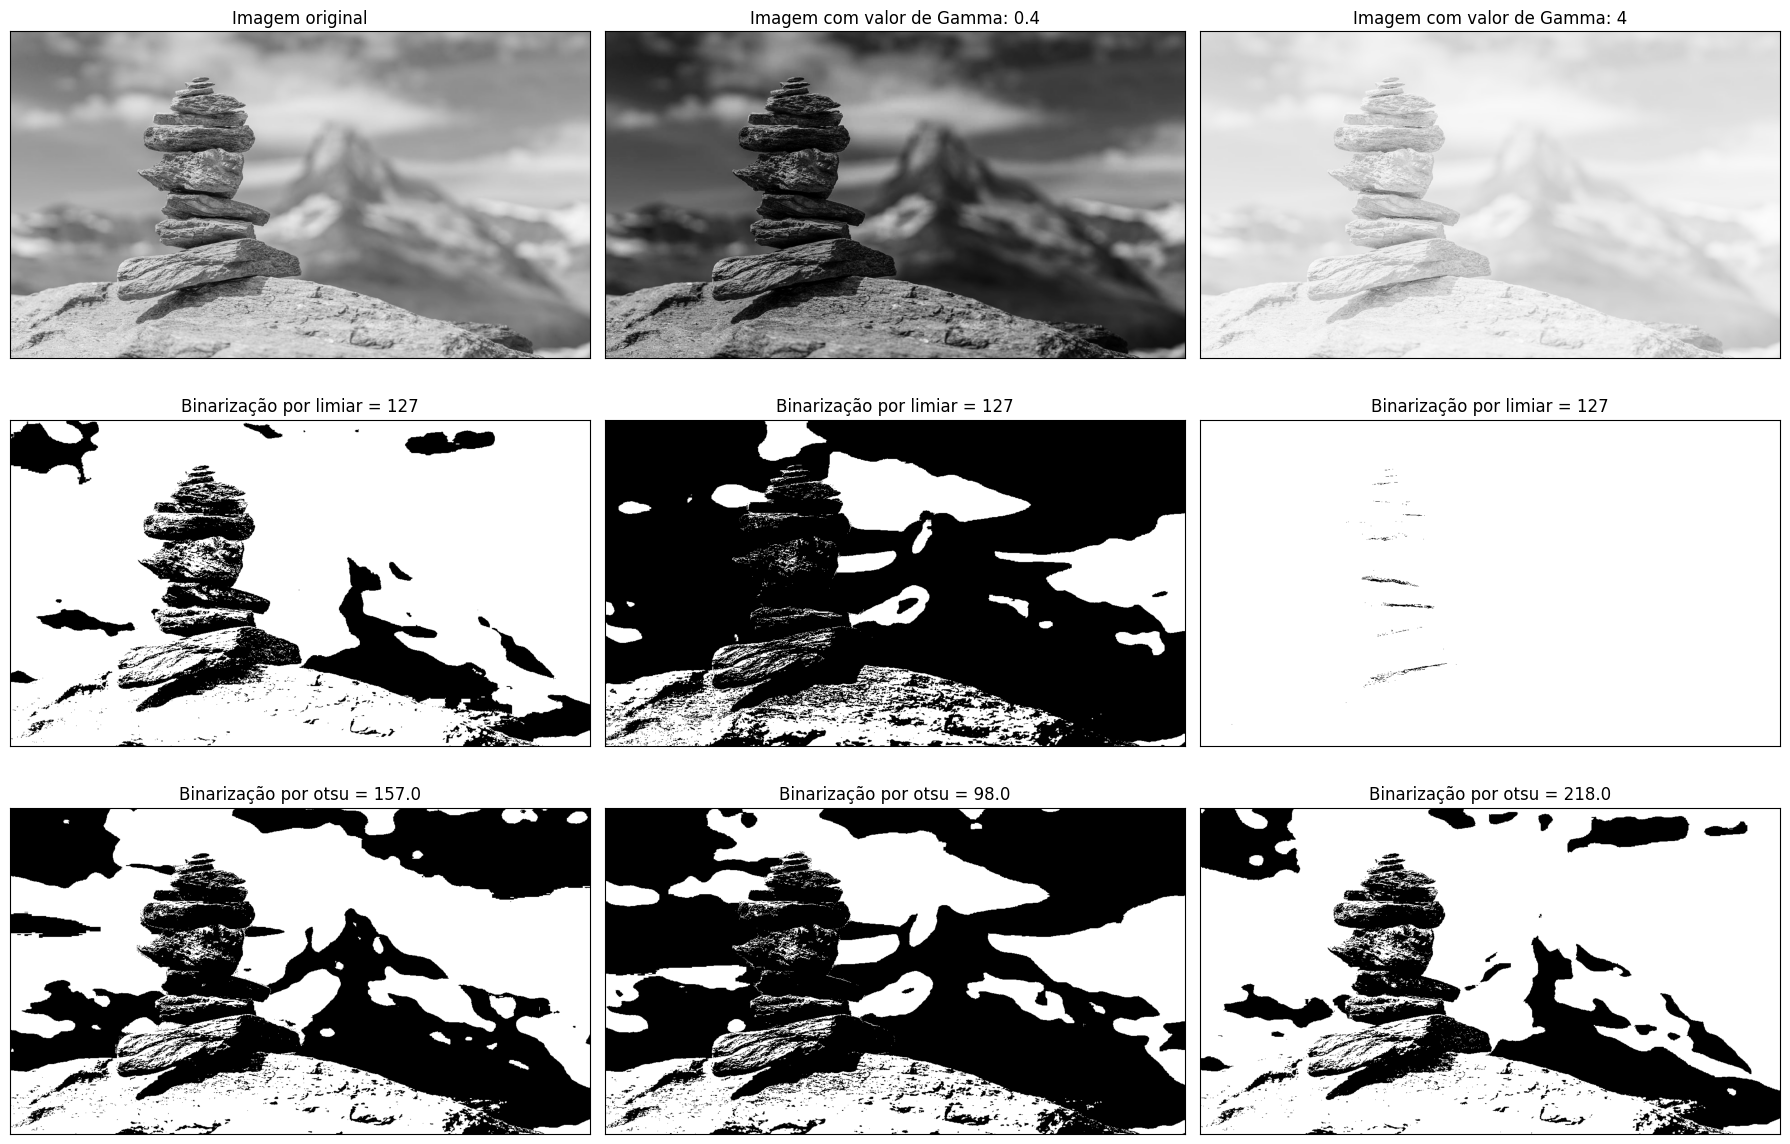

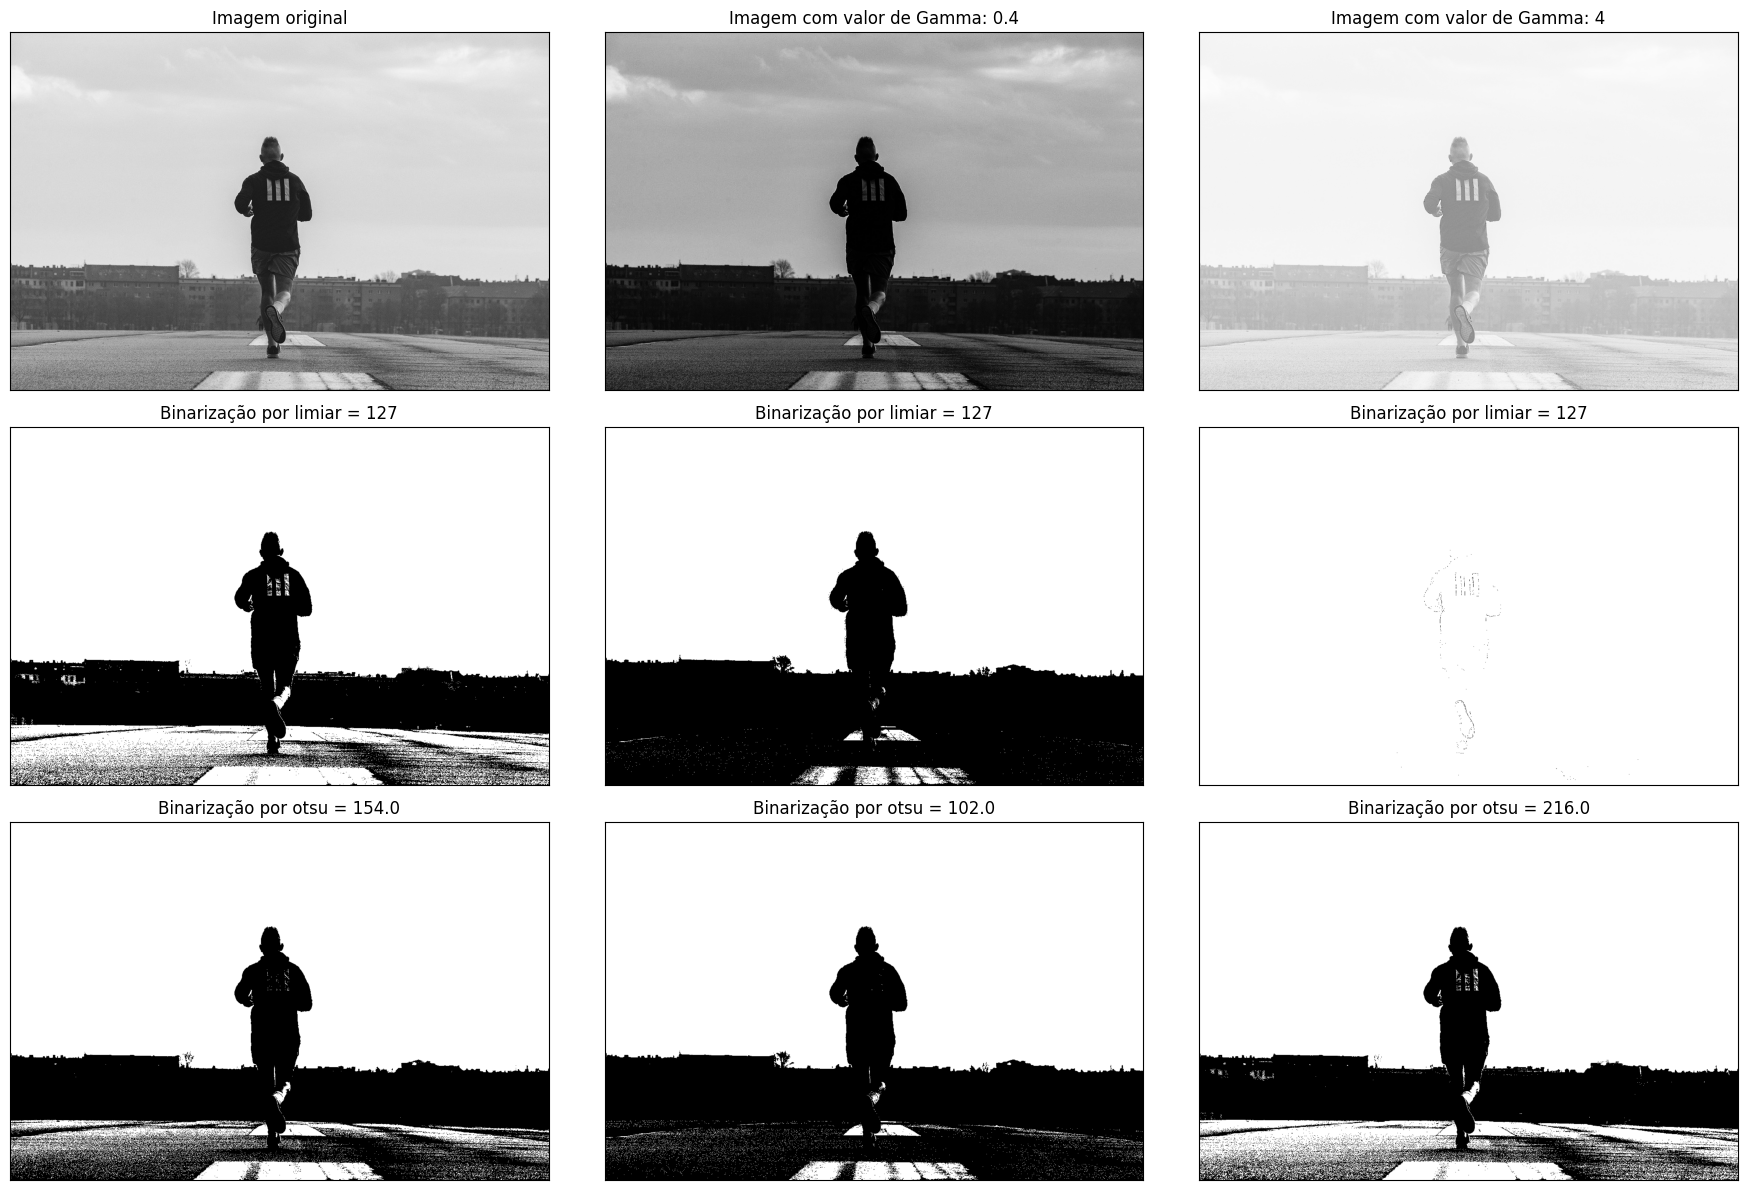

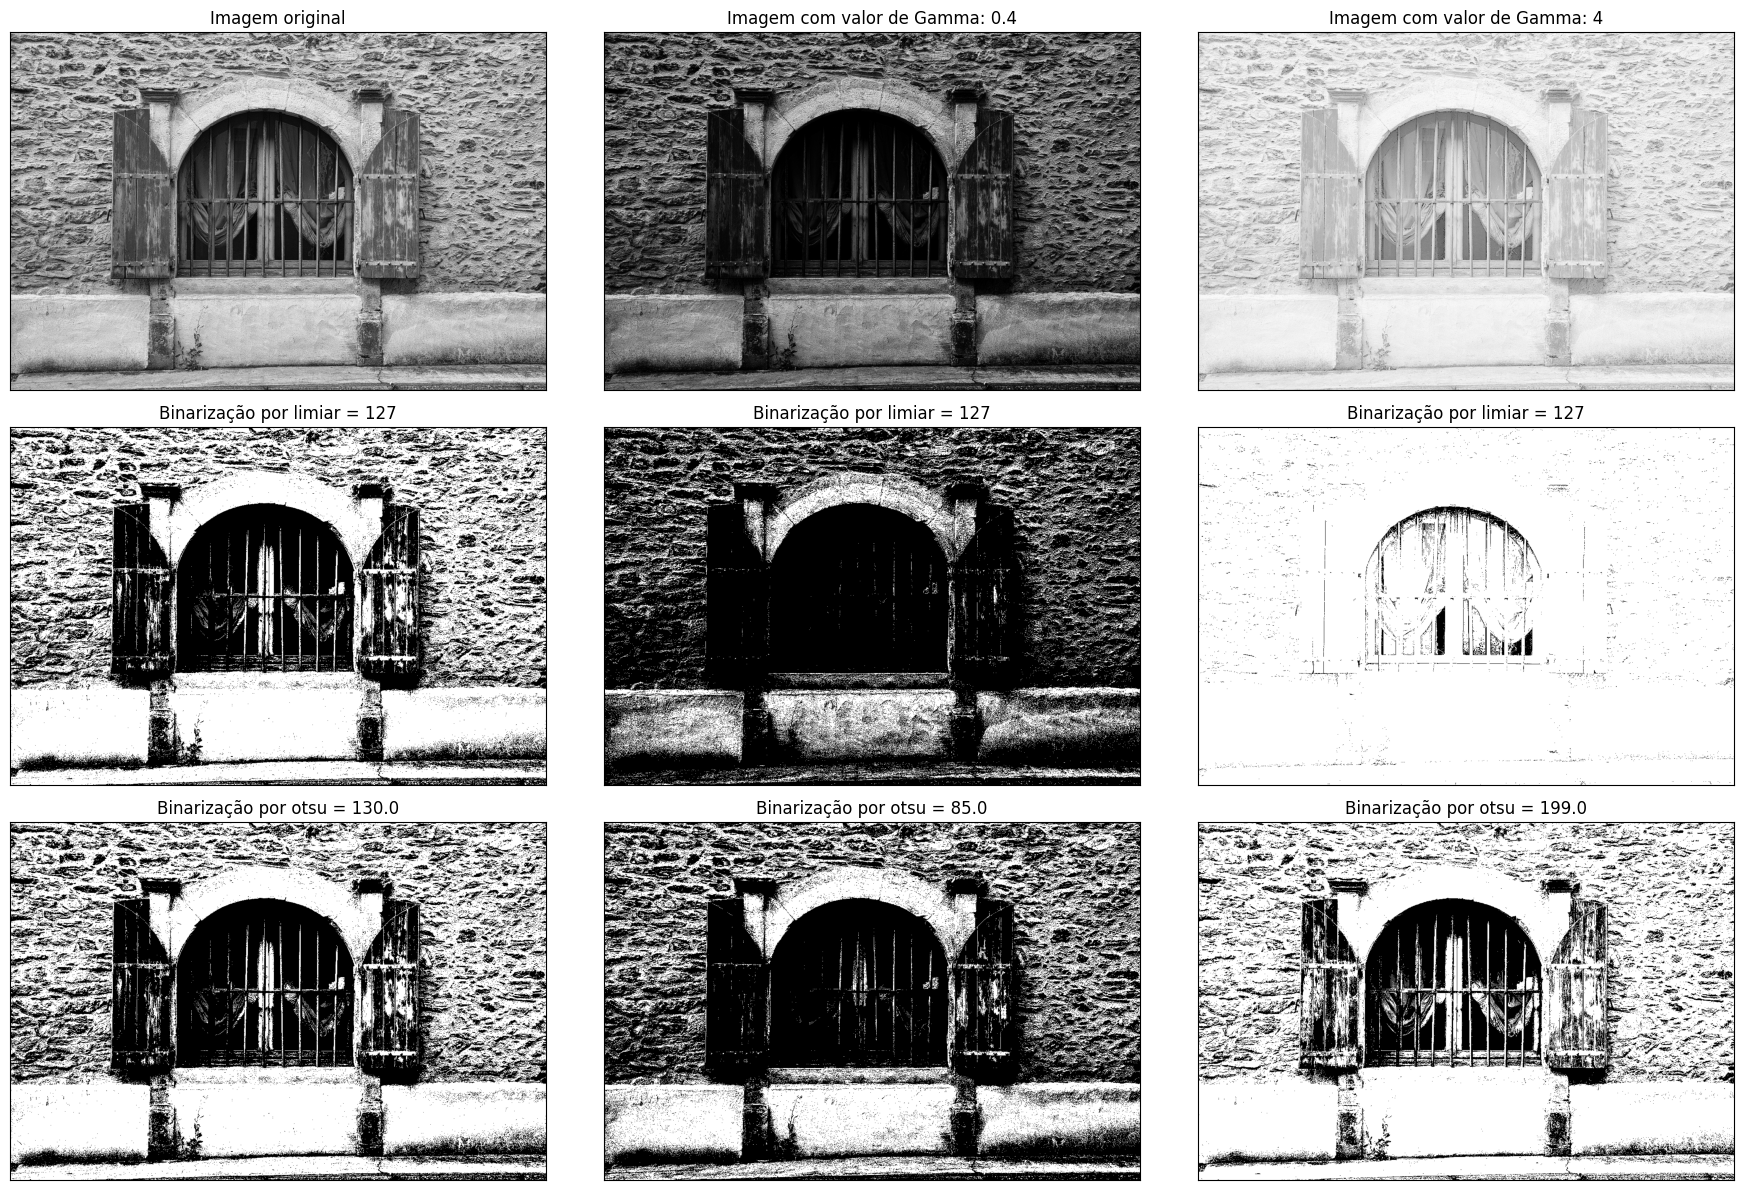

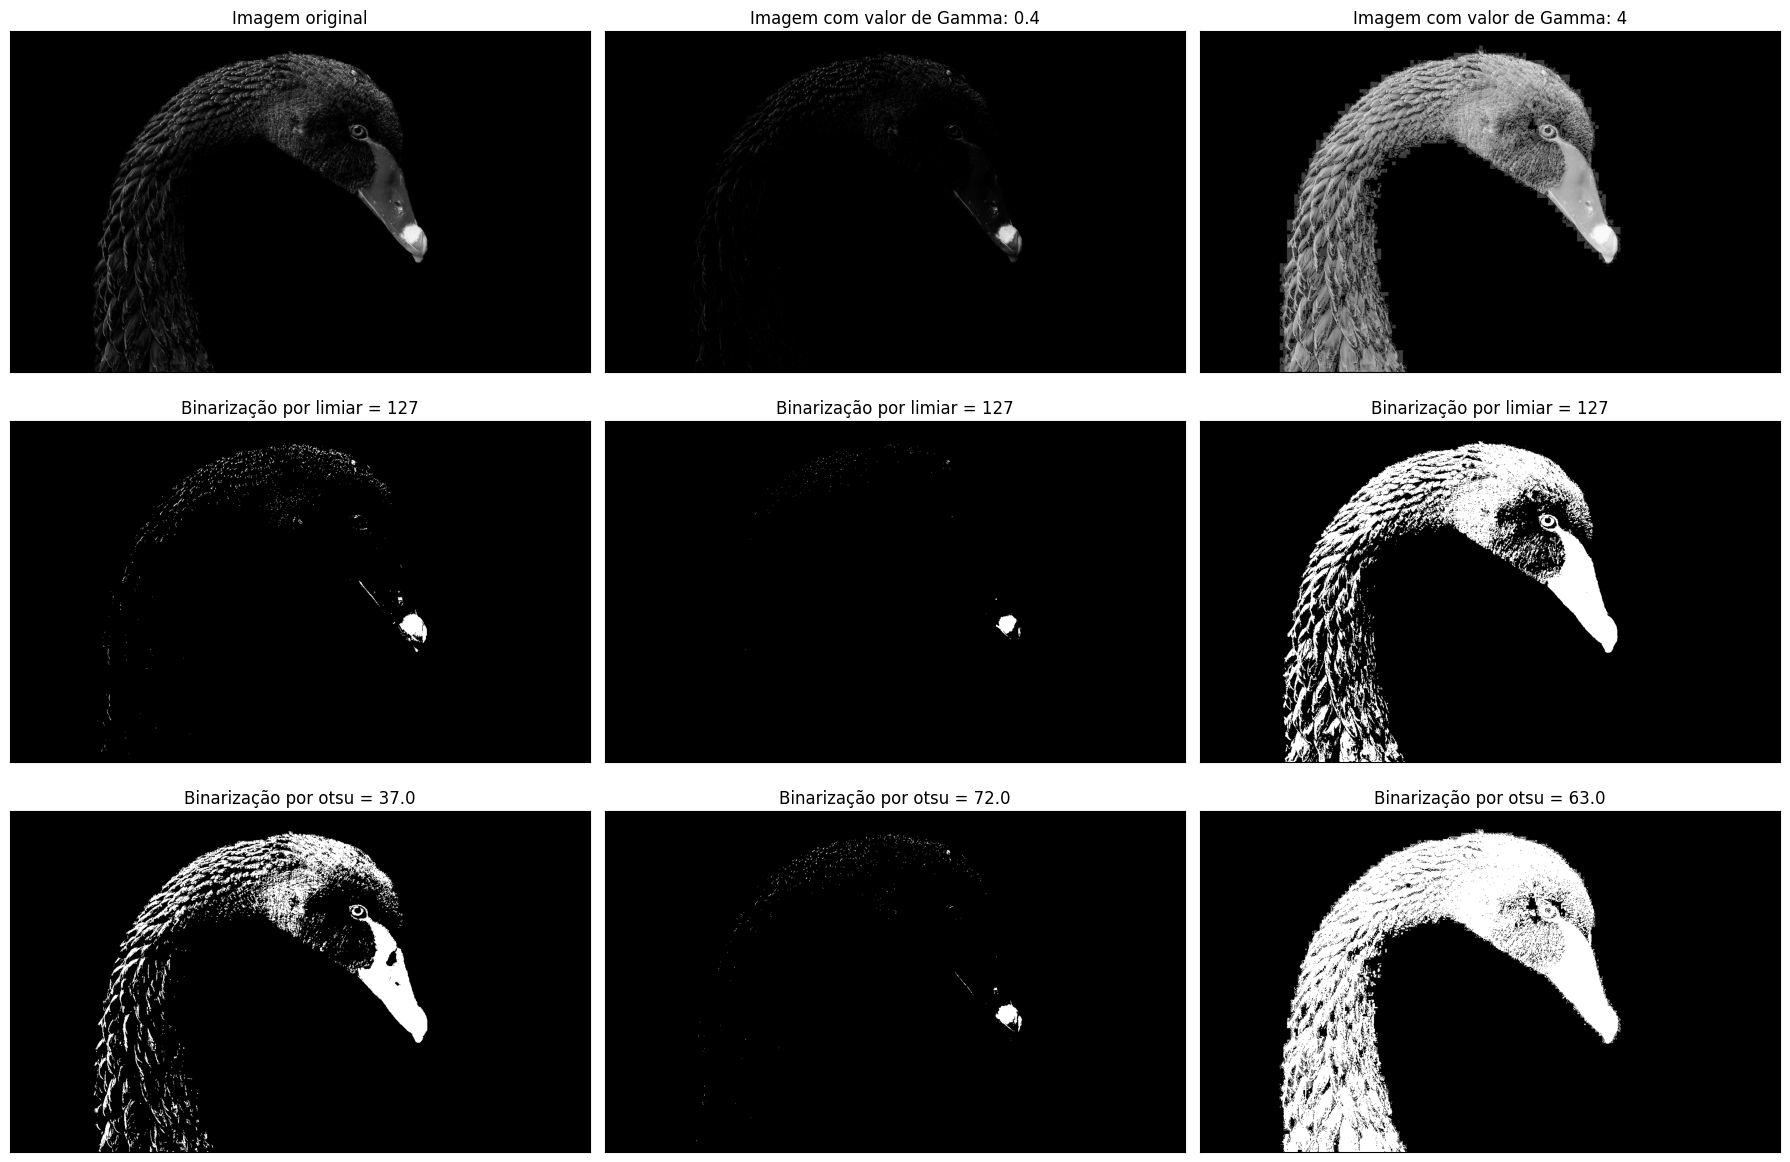

In [13]:
limiar = 127
titulos_gamma = titulos

for g in range(len(imagens_gamma)):
    imagens = []
    imagens_otsu = []
    valores_otsu = []
    
    for t in range(len(imagens_gamma[g])):
        _, thresh = cv2.threshold(imagens_gamma[g][t], limiar, 255, cv2.THRESH_BINARY)
        valor, otsu = cv2.threshold(imagens_gamma[g][t], 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        imagens.append(thresh)
        imagens_otsu.append(otsu)
        valores_otsu.append(valor)

    fig, axes = plt.subplots(3, 3, figsize=(18, 12))

    for i in range(3):
        axes[0, i].imshow(cv2.cvtColor(imagens_gamma[g][i], cv2.COLOR_BGR2RGB), cmap='gray')
        axes[0, i].set_title(titulos_gamma[i])
        axes[0, i].set_xticks([]), axes[0, i].set_yticks([])

    for i in range(3):
        axes[1, i].imshow(cv2.cvtColor(imagens[i], cv2.COLOR_BGR2RGB), cmap='gray')
        axes[1, i].set_title(f'Binarização por limiar = {limiar}')
        axes[1, i].set_xticks([]), axes[1, i].set_yticks([])

    for i in range(3):
        axes[2, i].imshow(cv2.cvtColor(imagens_otsu[i], cv2.COLOR_BGR2RGB), cmap='gray')
        axes[2, i].set_title(f'Binarização por otsu = {valores_otsu[i]}')
        axes[2, i].set_xticks([]), axes[2, i].set_yticks([])

    plt.tight_layout()
    plt.show()
